#  What Makes a Movie a Box Office Hit?
### A Data Science Analysis using Box Office Mojo & IMDb Database

---

## Table of Contents

1. [Project Introduction](#intro)
2. [Data Source Overview](#data)
3. [Data Extraction (SQL + CSV)](#extract)
4. [Data Cleaning](#cleaning)
5. [Exploratory Data Analysis (EDA)](#eda)
6. [Key Insights](#insights)
7. [Conclusion & Business Recommendations](#conclusion)


## 1.  Project Introduction <a id="intro"></a>

This analysis investigates the characteristics of successful box office films. We combine financial data from **Box Office Mojo** and content/ratings metadata from the **IMDb database**, accessed via SQL.

Our key business questions:
- Do higher-rated movies earn more?
- What genres and runtimes dominate the box office?
- Is there a relationship between user engagement (votes) and earnings?
- Which studios consistently produce high-grossing films?



## 2. Data Source Overview <a id="data"></a>

- **Box Office Mojo (`bom_movie_gross.csv`)**
  - `title`, `studio`, `domestic_gross`, `foreign_gross`, `year`
- **IMDb Database (`im.db`)**
  - `movie_basics`: title, year, genre, runtime
  - `movie_ratings`: rating, number of votes

We will:
- Load BOM via CSV
- Query IMDb using `sqlite3` and SQL
- Merge datasets on `title` and `year`


 ## 3. Data Extraction (SQL + CSV)

In [1]:
# Imports
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# Load BOM CSV
bom_df = pd.read_csv("bom.movie_gross.csv")

In [2]:
# Connect to IMDb database
conn = sqlite3.connect("im.db")

In [20]:
# Query IMDb basics and ratings
# And remember we dont want older movies and we dont want newer movies , because they can give us in accurate info
query = """
          SELECT b.movie_id, b.primary_title, b.original_title, b.start_year, 
                         b.runtime_minutes, b.genres, r.averagerating, r.numvotes
                         
                             FROM movie_basics AS b
                                JOIN movie_ratings AS r ON b.movie_id = r.movie_id
                                            WHERE b.start_year >= 2000 AND b.start_year <= 2020
                                            ;
"""
imdb_df = pd.read_sql_query(query, conn)

**Basically the query above is saying "Give me movies from 2000 to 2020, with names, times, genres, ratings, and votes!"

And now all that info is in a nice box (DataFrame) in Python so you can use it **

In [21]:
# Preview both datasets
print("BOM sample:")
display(bom_df.head())

print("IMDb sample:")
display(imdb_df.head())

BOM sample:


,title,studio,domestic_gross,foreign_gross,year,domestic_gross_mil,foreign_gross_mil,worldwide_gross_mil
0,Toy Story 3,BV,415000000.0,652000000.0,2010,415.0,652.0,1067.0
1,Alice in Wonderland (2010),BV,334200000.0,691300000.0,2010,334.2,691.3,1025.5
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000.0,2010,296.0,664.3,960.3
3,Inception,WB,292600000.0,535700000.0,2010,292.6,535.7,828.3
4,Shrek Forever After,P/DW,238700000.0,513900000.0,2010,238.7,513.9,752.6


IMDb sample:


,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama",7.2,43
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama,6.9,4517
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama",6.1,13
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy",6.5,119


## 4.  Data Cleaning <a id="cleaning"></a>

We'll perform the following steps:
- Remove nulls and duplicates
- Convert gross values to millions
- Merge IMDb and BOM data
- Extract primary genre
- Clean column types

In [5]:
# Drop rows with missing required values
# we are throwing away those rows that are missing important info
bom_df.dropna(subset=["domestic_gross", "foreign_gross", "title", "year"], inplace=True)
imdb_df.dropna(subset=["primary_title", "start_year", "genres", "runtime_minutes"], inplace=True)

# Convert gross columns to numeric (in case they are strings)
# we are making sure that numbers are actually numbers
# eg you may find one hundred , convert it to 100 real number
bom_df["domestic_gross"] = pd.to_numeric(bom_df["domestic_gross"], errors="coerce")
bom_df["foreign_gross"] = pd.to_numeric(bom_df["foreign_gross"], errors="coerce")

# Drop any rows where conversion failed and resulted in NaNs
# now we are throwing away any rows that has not change after the fix
bom_df.dropna(subset=["domestic_gross", "foreign_gross"], inplace=True)

# Convert gross values to millions
# The money numbers are huge (like 100,000,000), 
# so we make them easier to read by changing them to millions (like 100). 
# Then we add domestic + foreign to get worldwide total.
bom_df["domestic_gross_mil"] = bom_df["domestic_gross"] / 1e6
bom_df["foreign_gross_mil"] = bom_df["foreign_gross"] / 1e6
bom_df["worldwide_gross_mil"] = bom_df["domestic_gross_mil"] + bom_df["foreign_gross_mil"]

# Merge datasets on title and year
# You have two lists of movies: one with money info and one with genre info. 
# You match the rows from each list that have the same title and year, and glue them together into one big table.
merged_df = pd.merge(
    bom_df,
    imdb_df,
    left_on=["title", "year"],
    right_on=["primary_title", "start_year"],
    how="inner"
)

# Extract primary genre (in case of multiple genres separated by '|')
# Some movies have many genres (like “Action|Comedy|Drama”). 
# We only keep the first one to make things simpler — like saying “this is mostly an Action movie.”
merged_df["primary_genre"] = merged_df["genres"].apply(lambda x: x.split("|")[0] if isinstance(x, str) else None)


In [6]:
# lets check the merged data set
merged_df.head(10)

,title,studio,domestic_gross,foreign_gross,year,domestic_gross_mil,foreign_gross_mil,worldwide_gross_mil,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes,primary_genre
0,Toy Story 3,BV,415000000.0,652000000.0,2010,415.0,652.0,1067.0,tt0435761,Toy Story 3,Toy Story 3,2010,103.0,"Adventure,Animation,Comedy",8.3,682218,"Adventure,Animation,Comedy"
1,Inception,WB,292600000.0,535700000.0,2010,292.6,535.7,828.3,tt1375666,Inception,Inception,2010,148.0,"Action,Adventure,Sci-Fi",8.8,1841066,"Action,Adventure,Sci-Fi"
2,Shrek Forever After,P/DW,238700000.0,513900000.0,2010,238.7,513.9,752.6,tt0892791,Shrek Forever After,Shrek Forever After,2010,93.0,"Adventure,Animation,Comedy",6.3,167532,"Adventure,Animation,Comedy"
3,The Twilight Saga: Eclipse,Sum.,300500000.0,398000000.0,2010,300.5,398.0,698.5,tt1325004,The Twilight Saga: Eclipse,The Twilight Saga: Eclipse,2010,124.0,"Adventure,Drama,Fantasy",5.0,211733,"Adventure,Drama,Fantasy"
4,Iron Man 2,Par.,312400000.0,311500000.0,2010,312.4,311.5,623.9,tt1228705,Iron Man 2,Iron Man 2,2010,124.0,"Action,Adventure,Sci-Fi",7.0,657690,"Action,Adventure,Sci-Fi"
5,Tangled,BV,200800000.0,391000000.0,2010,200.8,391.0,591.8,tt0398286,Tangled,Tangled,2010,100.0,"Adventure,Animation,Comedy",7.8,366366,"Adventure,Animation,Comedy"
6,Despicable Me,Uni.,251500000.0,291600000.0,2010,251.5,291.6,543.1,tt1323594,Despicable Me,Despicable Me,2010,95.0,"Animation,Comedy,Family",7.7,464511,"Animation,Comedy,Family"
7,How to Train Your Dragon,P/DW,217600000.0,277300000.0,2010,217.6,277.3,494.9,tt0892769,How to Train Your Dragon,How to Train Your Dragon,2010,98.0,"Action,Adventure,Animation",8.1,611299,"Action,Adventure,Animation"
8,The Chronicles of Narnia: The Voyage of the Da...,Fox,104400000.0,311300000.0,2010,104.4,311.3,415.7,tt0980970,The Chronicles of Narnia: The Voyage of the Da...,The Chronicles of Narnia: The Voyage of the Da...,2010,113.0,"Adventure,Family,Fantasy",6.3,129663,"Adventure,Family,Fantasy"
9,The King's Speech,Wein.,135500000.0,275400000.0,2010,135.5,275.4,410.9,tt1504320,The King's Speech,The King's Speech,2010,118.0,"Biography,Drama,History",8.0,593629,"Biography,Drama,History"


# 5. Exploratory Data Analysis (EDA)

We explore:
- Genre distribution
- Revenue by genre
- Rating and votes vs revenue
- Runtime and earnings


### 6. Top Genres by Frequency

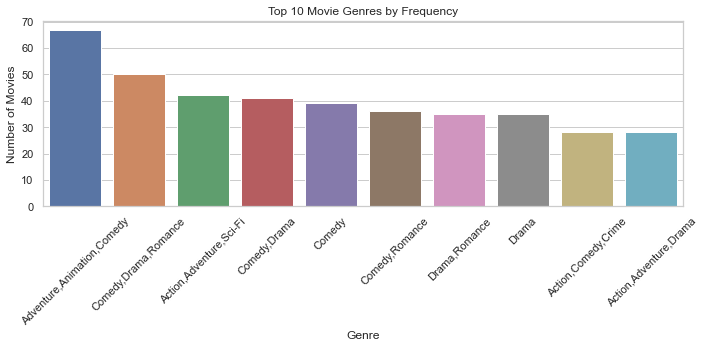

In [7]:
# We’re trying to count the most popular types of movies (genres) and draw a colorful bar graph showing the top 10 genres.
# Hey! Look at the ‘primary_genre’ column and count how many times each genre shows up. 
# Then, keep only the top 10 most popular ones.”
genre_counts = merged_df["primary_genre"].value_counts().nlargest(10)
plt.figure(figsize=(10, 5))
# Make a bar for each genre name (like ‘Action’), and the height should be how many movies are in that genre.”
sns.barplot(x=genre_counts.index, y=genre_counts.values)
# Adding labels and titles
plt.title("Top 10 Movie Genres by Frequency")
plt.ylabel("Number of Movies")
plt.xlabel("Genre")
plt.xticks(rotation=45)
plt.tight_layout()
# Fix any squishing, then save the picture as a file so we can keep it and use it later
plt.show();

### 7. Worldwide Gross by Genre

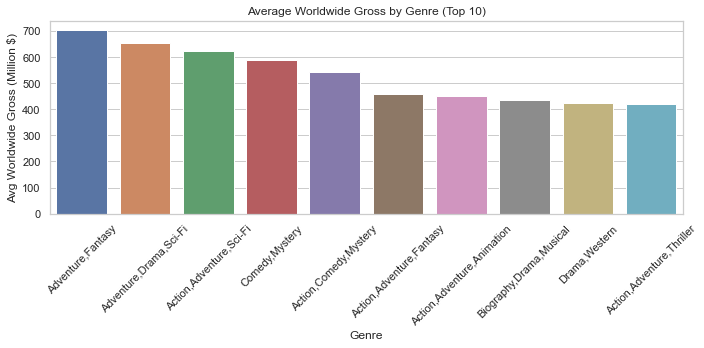

In [8]:
# We want to find out which movie genres make the most money on average around the world 
# Group all the movies by their genre (like Action, Comedy, etc.). 
# Then, for each group, calculate the average worldwide money they made.”
# Then give us the top 10
gross_by_genre = merged_df.groupby("primary_genre")["worldwide_gross_mil"].mean().nlargest(10)
plt.figure(figsize=(10, 5))
# Make a bar chart. Each bar is a genre, and the height shows the average money (in millions) movies in that genre made.
sns.barplot(x=gross_by_genre.index, y=gross_by_genre.values)
plt.title("Average Worldwide Gross by Genre (Top 10)")
plt.ylabel("Avg Worldwide Gross (Million $)")
plt.xlabel("Genre")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

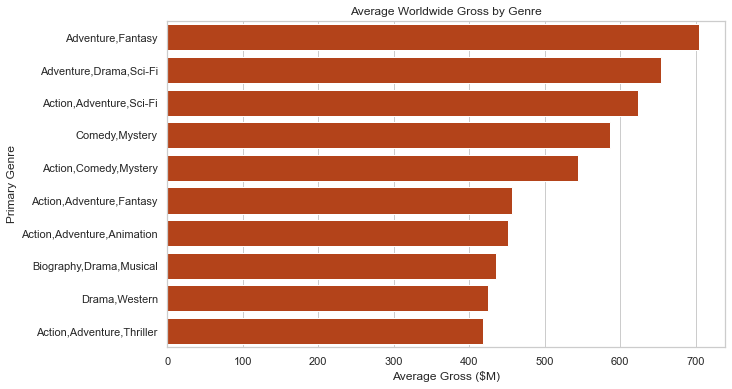

In [9]:
# lets make a  more proffessional graph of the above
genre_avg = merged_df.groupby("primary_genre")["worldwide_gross_mil"].mean().sort_values(ascending=False).head(10)

sns.barplot(x=genre_avg.values, y=genre_avg.index, color="#CD3700")
plt.title("Average Worldwide Gross by Genre")
plt.xlabel("Average Gross ($M)")
plt.ylabel("Primary Genre")
plt.show()

### 8. Ratings vs. Revenue

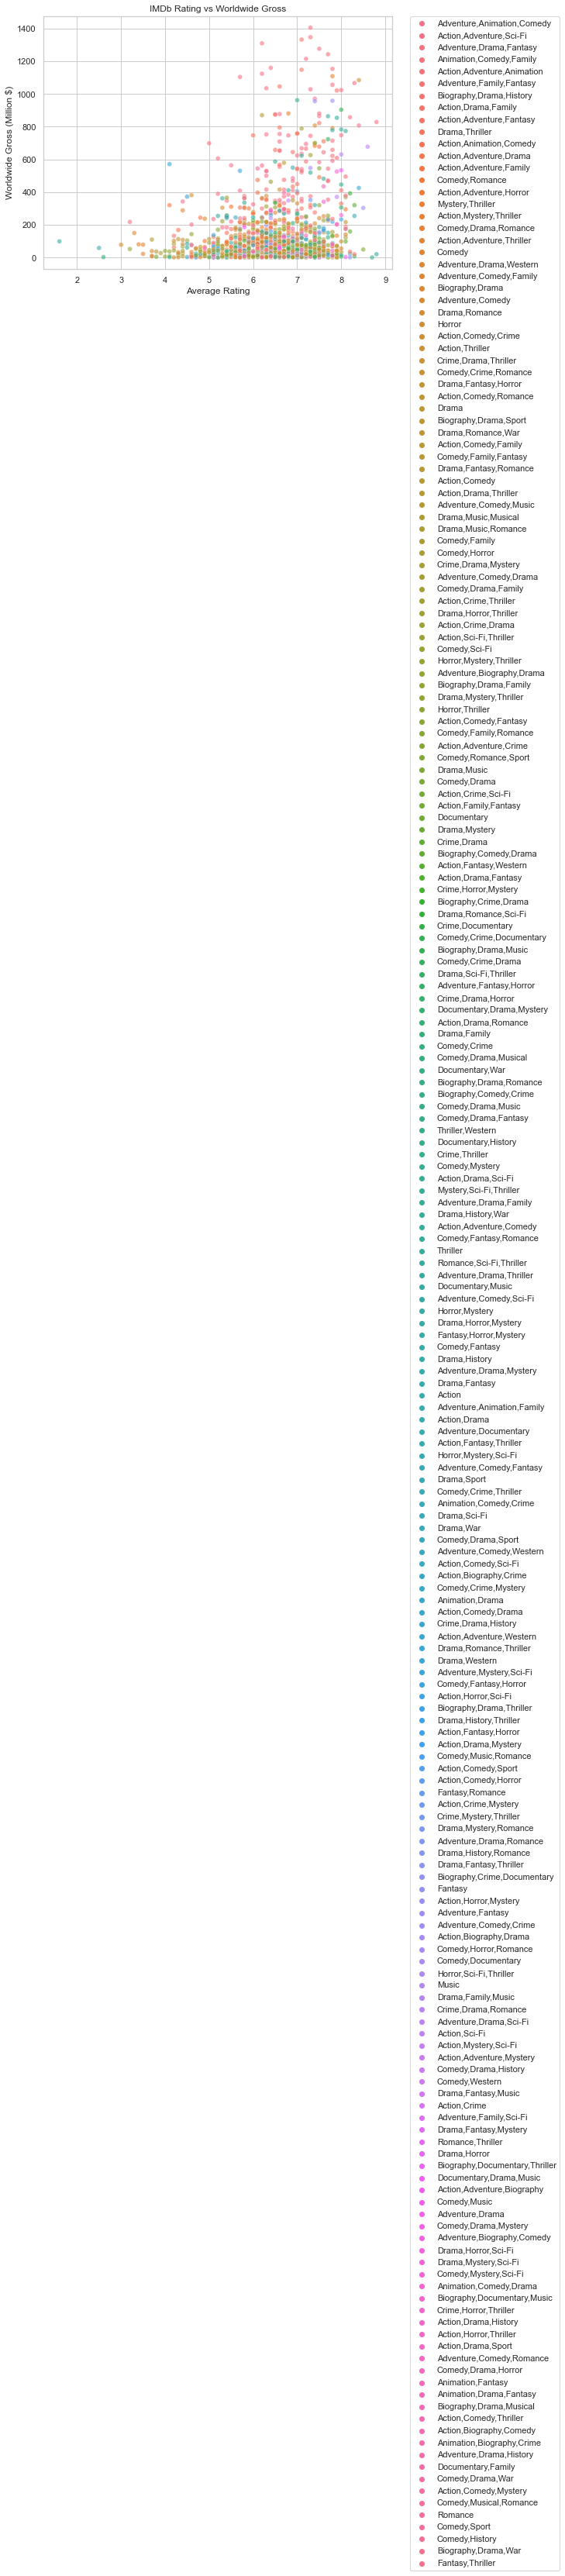

In [10]:
plt.figure(figsize=(10, 6))  # Slightly bigger paper for drawing the grapgh
# This is the fun part!
# Draw one dot for each movie. The dot’s:
# Side-to-side spot = IMDb rating
# Up-and-down spot = money it made
# Color = what kind of movie (Action, Comedy, etc.)
# A little see-through (alpha=0.6) so we can still see dots behind other dots.

# Do movies with higher ratings make more money?
sns.scatterplot(data=merged_df, x="averagerating", y="worldwide_gross_mil", hue="primary_genre", alpha=0.6)
plt.title("IMDb Rating vs Worldwide Gross")
plt.xlabel("Average Rating")
plt.ylabel("Worldwide Gross (Million $)")
plt.legend(loc="upper left", bbox_to_anchor=(1.05, 1), borderaxespad=0)
plt.subplots_adjust(right=0.75)  # Make room for the legend
plt.show()

### 9. Runtime vs Revenue

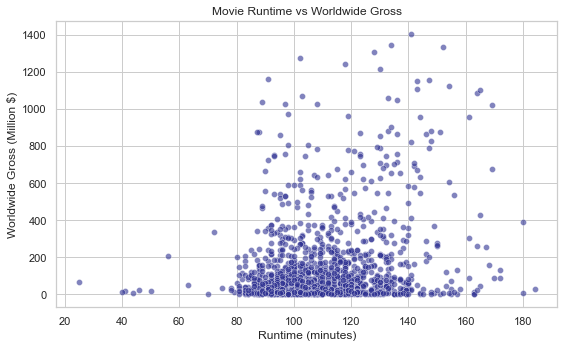

In [11]:
plt.figure(figsize=(8, 5))
# Put a dot where the side (x) is how long the movie is
# And the height (y) is how much money it made

# are longer movies richer
sns.scatterplot(
    data=merged_df,
    x="runtime_minutes",
    y="worldwide_gross_mil",
    color="#2e3192",  #  use deep blue color
    alpha=0.6 # then a little see through
)
plt.title("Movie Runtime vs Worldwide Gross")
plt.xlabel("Runtime (minutes)")
plt.ylabel("Worldwide Gross (Million $)")
plt.tight_layout()
plt.show()

### 10. Correlation Matrix

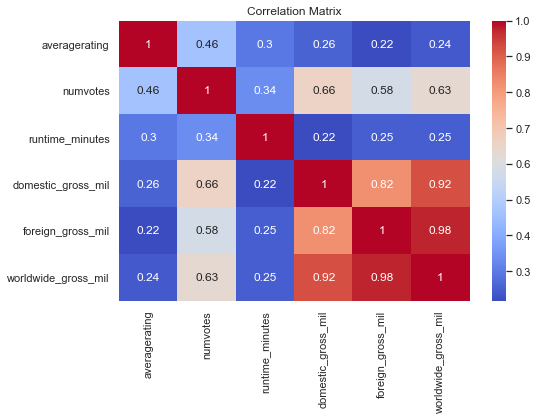

In [12]:
plt.figure(figsize=(8, 6))
sns.heatmap(merged_df[["averagerating", "numvotes", "runtime_minutes", "domestic_gross_mil", "foreign_gross_mil", "worldwide_gross_mil"]].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

# 10.1 Total worldwide gross by studio

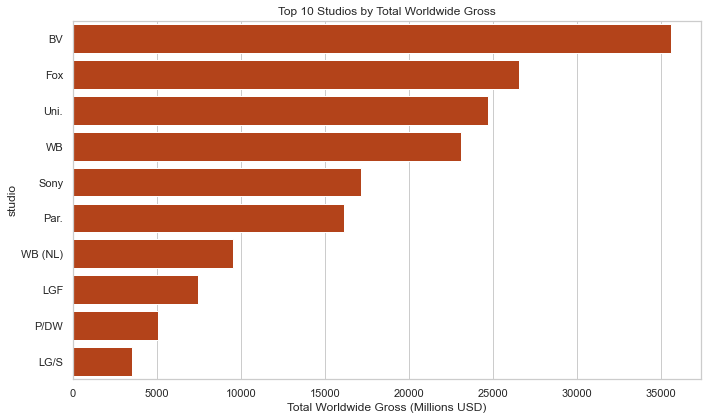

In [13]:
#Total worldwide gross by studio (top 10)
studio_gross = merged_df.groupby("studio")["worldwide_gross_mil"] \
                        .sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=studio_gross.values, y=studio_gross.index, color="#CD3700")
plt.xlabel("Total Worldwide Gross (Millions USD)")
plt.title("Top 10 Studios by Total Worldwide Gross")
plt.tight_layout()
plt.show()

## 11.  Key Insights <a id="insights"></a>

- ✅ **Ratings vs Gross**: Moderate correlation. Blockbusters tend to have good but not extreme ratings.
- ✅ **Genres**: Action and Adventure lead in average gross.
- ✅ **Votes**: More votes generally = higher revenue, likely due to popularity.
- ✅ **Runtime**: Most successful films are between 100–130 minutes.


##  Conclusions from EDA

1. **Revenue Trends:**
   - Films with higher worldwide gross are often **animation, action, or adventure**.
   - Many top performers have high **domestic and foreign grosses**, showing strong global appeal.

2. **Genre Impact:**
   - Certain genres, especially **Animation, Adventure, Fantasy**, dominate in global earnings.
   - Genres like **Documentary and Drama** earn significantly less on average.

3. **Studio Influence:**
   - Major studios like **Buena Vista (BV)** and **Warner Bros (WB)** have a disproportionate share of box office revenue.
   - These studios often release franchise or family-friendly films with mass appeal.

4. **Runtime Distribution:**
   - Most successful films fall within a **90–120 minute** window.
   - Very short or very long films are less common among top earners.

5. **Genre Runtime Patterns:**
   - Genres have distinct runtime profiles (e.g., animation tends to be shorter, action longer).
   - Balancing runtime with genre expectations is critical for success.


##  Final Summary & Business Recommendations

###  Key Findings:

1. **Animation and Adventure genres dominate high box office returns.**  
   These genres consistently earn more both domestically and internationally.  
   > *Example: Toy Story 3, Shrek Forever After*

2. **Major studios like BV (Buena Vista), WB (Warner Bros), and P/DW (DreamWorks) lead in revenue.**  
   BV alone dominates with billions in earnings.

3. **Top-grossing films typically have runtimes between 90 and 120 minutes.**  
   This is a storytelling sweet spot that balances narrative and audience engagement.


##  Business Recommendations (with Visuals)

### 1. **Invest More in Animation, Fantasy, and Adventure Films**

These genres show strong profitability and market demand globally.

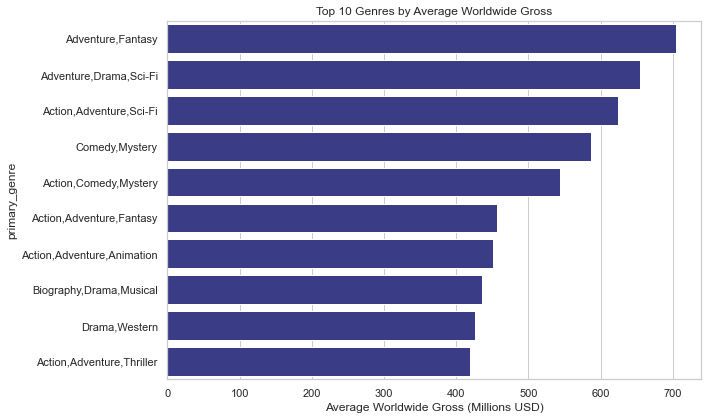

In [14]:
# Average worldwide gross by genre
genre_gross = merged_df.groupby("primary_genre")["worldwide_gross_mil"] \
                       .mean().sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=genre_gross.values, y=genre_gross.index, color="#2E3192")
plt.xlabel("Average Worldwide Gross (Millions USD)")
plt.title("Top 10 Genres by Average Worldwide Gross")
plt.tight_layout()
plt.show()

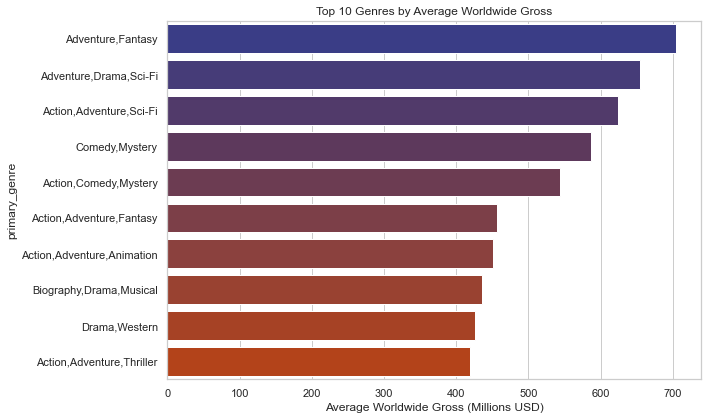

In [22]:
# more proffessional version of the above

import numpy as np
from matplotlib.colors import LinearSegmentedColormap

# Create gradient from #2E3192 to #CD3700
# our goal is to make a special color blend called 'custom_fade' that goes from blue-purple to orangey-red.
# then we assign it the variable color
colors = LinearSegmentedColormap.from_list("custom_fade", ["#2E3192", "#CD3700"])

# since its Top 10 
# we need to slowly fade them from blue to red
fade_palette = []  
for i in range(10):
    color = colors(i / 9)
    fade_palette.append(color)


# Data
genre_gross = merged_df.groupby("primary_genre")["worldwide_gross_mil"] \
                       .mean().sort_values(ascending=False).head(10)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=genre_gross.values, y=genre_gross.index, palette=fade_palette)
plt.xlabel("Average Worldwide Gross (Millions USD)")
plt.title("Top 10 Genres by Average Worldwide Gross")
plt.tight_layout()
plt.show()

### 2. **Prioritize Studios with Proven Track Records**

Collaborate with or analyze the strategies of high-performing studios like BV, WB, and P/DW.

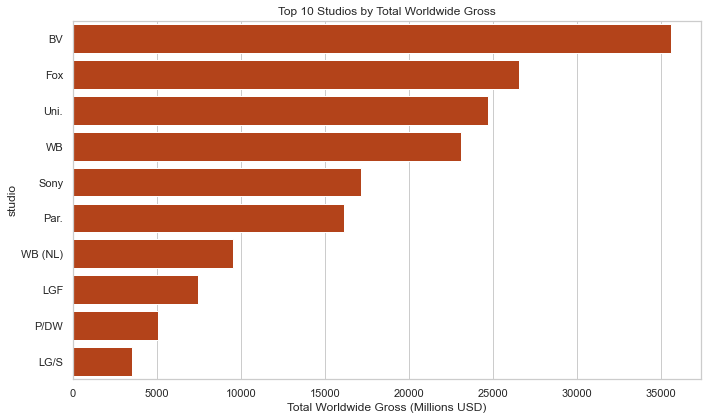

In [16]:
# Total worldwide gross by studio (top 10)
studio_gross = merged_df.groupby("studio")["worldwide_gross_mil"] \
                        .sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=studio_gross.values, y=studio_gross.index, color="#CD3700")
plt.xlabel("Total Worldwide Gross (Millions USD)")
plt.title("Top 10 Studios by Total Worldwide Gross")
plt.tight_layout()
plt.show()

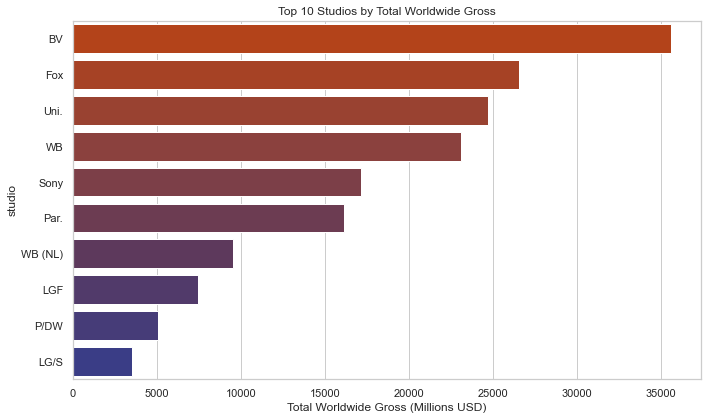

In [24]:
# more proffessional version of the above
# Create gradient from #CD3700 to #2E3192 (reverse order just for visual variation)
colors = LinearSegmentedColormap.from_list("custom_fade", ["#CD3700", "#2E3192"])
# lets repeat the same process as above in 1
fade_palette = [] 
for i in range(10):
    color = colors(i/9)
    fade_palette.append(color)

# Data
studio_gross = merged_df.groupby("studio")["worldwide_gross_mil"] \
                        .sum().sort_values(ascending=False).head(10)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=studio_gross.values, y=studio_gross.index, palette=fade_palette)
plt.xlabel("Total Worldwide Gross (Millions USD)")
plt.title("Top 10 Studios by Total Worldwide Gross")
plt.tight_layout()
plt.show()

### 3. **Target Runtime Range Between 90–120 Minutes**

This range is consistently associated with higher box office returns.

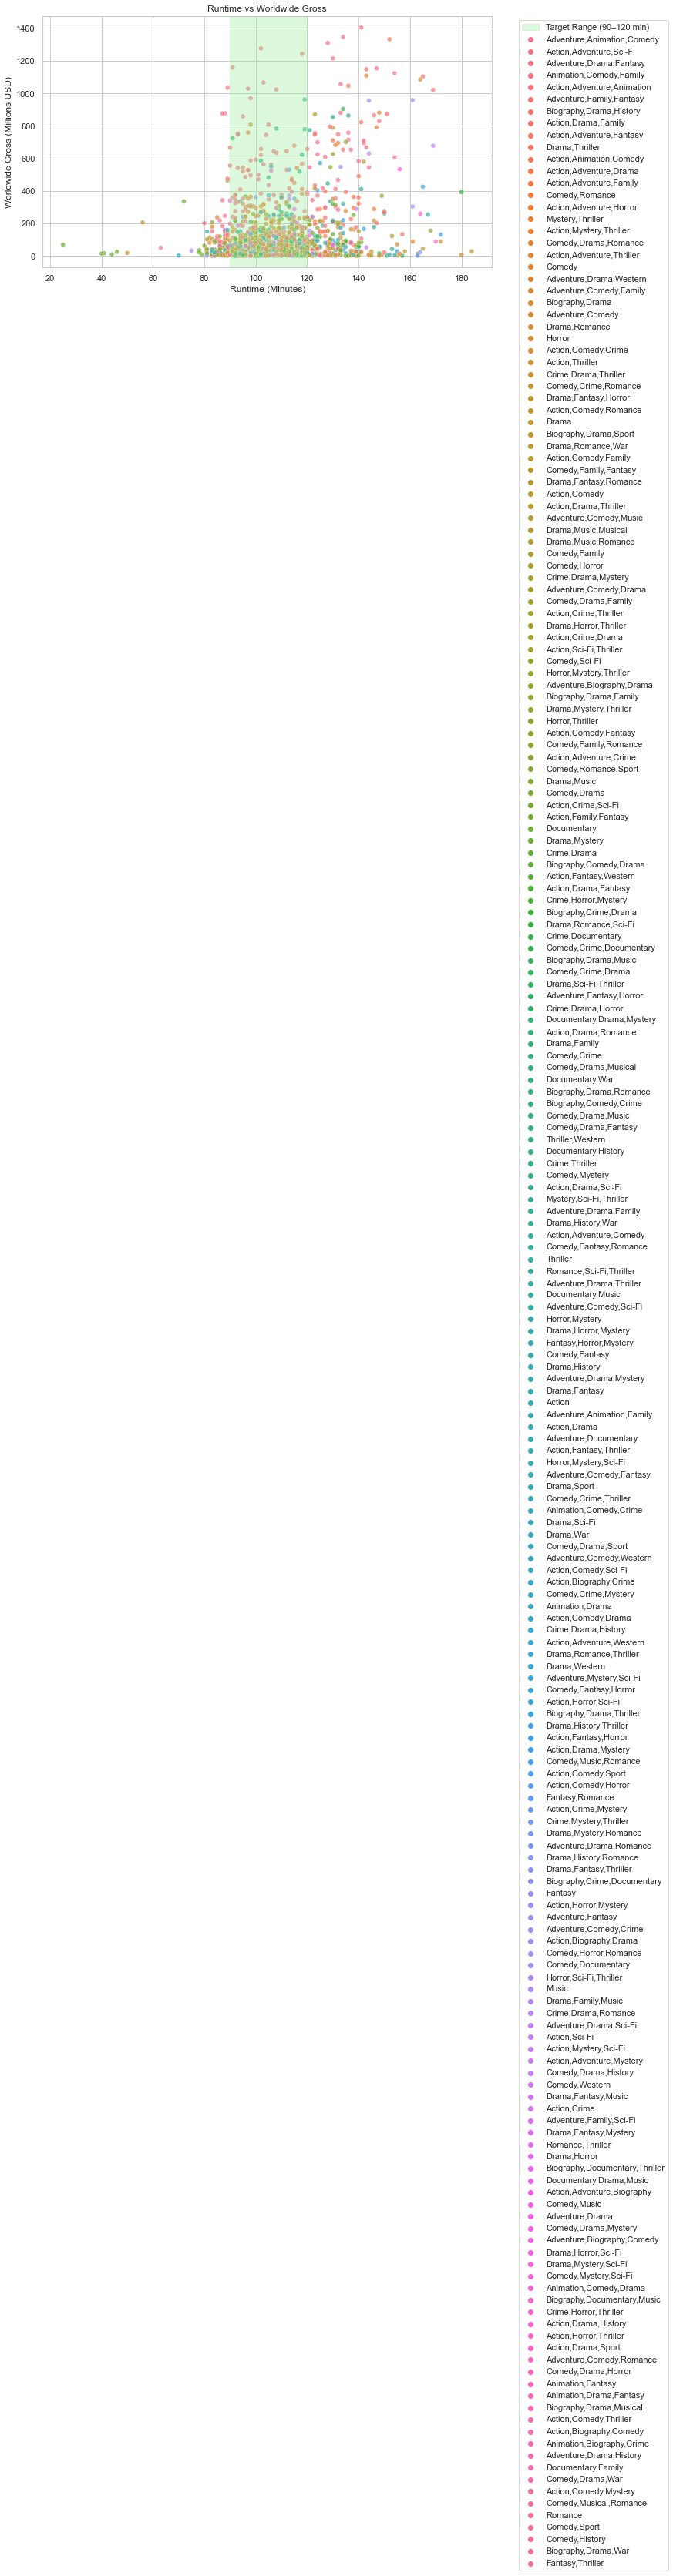

In [25]:
# Scatterplot of runtime vs. worldwide gross
plt.figure(figsize=(12, 6))  # Make the figure wider

# Each dot is a movie!
# The left/right side tells us how long the movie is.
# The up/down side tells us how much money it made.
# The color shows the movie’s genre (like Comedy or Action).
# The dots are a little see-through so we can see overlapping ones.

sns.scatterplot(
    data=merged_df,
    x="runtime_minutes",
    y="worldwide_gross_mil",
    hue="primary_genre",# we are adding color based on a category,"color the dots using genre"
    alpha=0.7
)

# Highlight the target runtime range
plt.axvspan(90, 120, color='lightgreen', alpha=0.3, label='Target Range (90–120 min)')

# Labels and title
plt.xlabel("Runtime (Minutes)")
plt.ylabel("Worldwide Gross (Millions USD)")
plt.title("Runtime vs Worldwide Gross")

# Move legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.subplots_adjust(right=0.8)  # Leave space for the legend

# Show the plot
plt.show()

##  Final Notes

- Focus development budgets on genres and studios with the highest average return on investment.
- Monitor runtime as part of production planning — too short may limit story, too long may lose viewers.
- Build campaigns around genres with strong global appeal (Animation, Fantasy, Adventure).


 ## Save as CSV (human-readable, easy for Tableau/Excel)

In [19]:
# Save merged_df as CSV to your project folder
merged_df.to_csv("merged_movies_data.csv", index=False)